# Introduction to BERT

## Overview of notebook

1. Motivating the need for BERT; how do other methods for generating sequence representations fail?
    - Static word embeddings
    - Equal weigth to all words in a sequence
    - Methods are not trained with a sequence-level task
2. Brief explanation of BERT
3. Using BERT features for a prediction task
    - Predict the NAICS-2 sector of a sentence
    - Compare results with Word2Vec features
4. Domain-specific features: using a model trained on the domain of interest
    - Compare results to generic BERT and word2vec
5. Finetuning for our own task
    - Compare with all previous results
    

## Useful external resources
- BERT paper: https://arxiv.org/pdf/1810.04805.pdf
- Book: https://web.stanford.edu/~jurafsky/slp3/11.pdf
- Book: https://web.stanford.edu/~jurafsky/slp3/9.pdf
- Jay Alammar: https://jalammar.github.io/illustrated-bert/
- Jay Alammar: https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
- Applied tutorial: https://www.youtube.com/watch?v=QEaBAZQCtwE

------------

# Setup

In [ ]:
# Instructions for Colab: 
# 1. First CHANGE RUNTIME TYPE to GPU 
# 2. Then run install commands commented out below
# 3. You might need to RESTART RUNTIME
# 4. Run git clone command to the get files from the public repository
# 5. Run the rest of the cells below

In [ ]:
# install required libraries
!pip3 install transformers                  # HuggingFace library for interacting with BERT (and multiple other models)
!pip3 install datasets                      # HuggingFace library to process dataframes
!pip3 install sentence-transformers         # library to use Sentence Similarity BERT
!pip3 install bertviz                       # visualize BERT's attention weigths
!pip3 install annoy                         # Spotify's library for finding nearest neighbours                     
!pip3 install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.9 MB/s 
     |████████████████████████████████| 596 kB 64.9 MB/s 
     |████████████████████████████████| 101 kB 14.1 MB/s 
     |████████████████████████████████| 6.6 MB 46.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 3.5 MB/s 
     |████████████████████████████████| 212 kB 51.5 MB/s 
     |████████████████████████████████| 1.1 MB 10.8 MB/s 
     |████████████████████████████████| 140 kB 59.6 MB/s 
     |████████████████████████████████| 127 kB 59.3 MB/s 
     |████████████████████████████████| 144 kB 59.2 MB/s 
     |████████████████████████████████| 271 kB 23.8 MB/s 
     |███████████

In [ ]:
# (COLAB) you might need to restart RUNTIME after installing packages!

In [ ]:
# (COLAB) clone the public Github repository
#!git clone https://github.com/yabramuvdi/pymodules-test.git

In [ ]:
import pandas as pd
import numpy as np
import gdown
import random
from tqdm.auto import tqdm
import time
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from annoy import AnnoyIndex
from scipy import spatial

from transformers import BertModel, AutoTokenizer, BertForSequenceClassification, pipeline, TrainingArguments, Trainer, utils
from transformers.pipelines.base import KeyDataset
from datasets import load_dataset, load_metric, Dataset, DatasetDict
from bertviz import model_view, head_view

from sentence_transformers import SentenceTransformer

from gensim.models import Word2Vec
import gensim.downloader as api

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# test GPU
print(f"GPU: {torch.cuda.is_available()}")

GPU: True


In [ ]:
# define paths and seed
seed = 92
data_path = "./"

In [ ]:
# define dictionary with paths to data in Google Drive
data_url_dict = {"10k_sent_2019":        ("https://drive.google.com/uc?id=17PQbZ6EotMxyhpt2Laqqh9z-EKUbwDhX", "parquet"),
                 "covariates_2019":      ("https://drive.google.com/uc?id=1ELRq69FOiFvNpSvXOijGeGKZB5DiNXt4", "csv"),
                 "naics2_codes":         ("https://drive.google.com/uc?id=1H4bFNVbEbhxQotoxsM3yf-JrtgKGXG0k", "csv")
                  }

In [ ]:
# download each file in the dictionary
for file_name, attributes in data_url_dict.items():
  url = attributes[0]
  extension = attributes[1]
  gdown.download(url, f"{file_name}.{extension}", quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=17PQbZ6EotMxyhpt2Laqqh9z-EKUbwDhX
To: /content/10k_sent_2019.parquet
100%|██████████| 162M/162M [00:02<00:00, 80.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ELRq69FOiFvNpSvXOijGeGKZB5DiNXt4
To: /content/covariates_2019.csv
100%|██████████| 428k/428k [00:00<00:00, 121MB/s]
Downloading...
From: https://drive.google.com/uc?id=1H4bFNVbEbhxQotoxsM3yf-JrtgKGXG0k
To: /content/naics2_codes.csv
100%|██████████| 868/868 [00:00<00:00, 2.22MB/s]


# Data

In [ ]:
# read data
df = pd.read_parquet(data_path + "10k_sent_2019.parquet")
df

,sentences,cik,year,sent_no,sent_id
0,You should carefully review the following disc...,1065088,2019,0,1065088_0
1,"Risk Factors That May Affect our Business, Res...",1065088,2019,1,1065088_1
2,Our operating and financial results are subjec...,1065088,2019,2,1065088_2
3,Our operating and financial results have varie...,1065088,2019,3,1065088_3
4,It is difficult for us to forecast the level o...,1065088,2019,4,1065088_4
...,...,...,...,...,...
1744126,,1069533,2019,189,1069533_189
1744127,The Company is generally isolated from commodi...,1069533,2019,190,1069533_190
1744128,,1069533,2019,191,1069533_191
1744129,"With respect to interest rate risk, the Compan...",1069533,2019,192,1069533_192


In [ ]:
# firm-level data
covariates = pd.read_csv(data_path + "covariates_2019.csv")
covariates.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,conm,curcd,act,at,emp,cik,costat,naics,naics2,naics2_name
0,1004,20200531,2019,INDL,C,D,STD,AIR,AAR CORP,USD,1438.700,2079.000,5.400,1750,A,423860,42,Wholesale Trade
1,1050,20191231,2019,INDL,C,D,STD,CECE,CECO ENVIRONMENTAL CORP,USD,179.498,408.637,0.830,3197,A,333413,33,Manufacturing
2,1078,20191231,2019,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,USD,15667.000,67887.000,107.000,1800,A,334510,33,Manufacturing
3,1104,20191231,2019,INDL,C,D,STD,ACU,ACME UNITED CORP,USD,73.146,110.749,0.441,2098,A,332215,33,Manufacturing
4,1117,20191231,2019,INDL,C,D,STD,BKTI,BK TECHNOLOGIES CORP,USD,23.886,37.940,0.111,2186,A,334220,33,Manufacturing


In [ ]:
# we will choose some specific firms of interest using their TIC identifiers
tics = ["AAPL", "GOOGL", "TWTR", "ORCL", "TSLA", "GM", "F", "BAC", "COF", "JPM", "AXP", "HBC2", "TGT", "M", "WMT", "COST", "BNED", "DIS", "FOXA", "ADSK", "CAT", "BA"]
covariates_focus = covariates.loc[covariates["tic"].isin(tics)]
covariates_focus = covariates_focus.groupby("tic", as_index=False).max()
covariates_focus

,tic,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,conm,curcd,act,at,emp,cik,costat,naics,naics2,naics2_name
0,AAPL,1690,20190930,2019,INDL,C,D,STD,APPLE INC,USD,162819.000,338516.000,137.000,320193,A,334220,33,Manufacturing
1,ADSK,1878,20200131,2019,INDL,C,D,STD,AUTODESK INC,USD,2659.300,6179.300,10.100,769397,A,519130,51,Information
2,AXP,1447,20191231,2019,INDL,C,D,STD,AMERICAN EXPRESS CO,USD,NaN,198321.000,64.500,4962,A,522210,52,Finance and Insurance
3,BA,2285,20191231,2019,INDL,C,D,STD,BOEING CO,USD,102229.000,133625.000,161.100,12927,A,336411,33,Manufacturing
4,BAC,7647,20191231,2019,INDL,C,D,STD,BANK OF AMERICA CORP,USD,NaN,2434079.000,208.131,70858,A,522110,52,Finance and Insurance
5,BNED,23208,20200430,2019,INDL,C,D,STD,BARNES & NOBLE EDUCATION INC,USD,584.919,1156.432,5.500,1634117,A,451211,45,Retail Trade
6,CAT,2817,20191231,2019,INDL,C,D,STD,CATERPILLAR INC,USD,39193.000,78453.000,102.300,18230,A,333120,33,Manufacturing
7,COF,30990,20191231,2019,INDL,C,D,STD,CAPITAL ONE FINANCIAL CORP,USD,NaN,390365.000,51.900,927628,A,522210,52,Finance and Insurance
8,COST,29028,20190831,2019,INDL,C,D,STD,COSTCO WHOLESALE CORP,USD,23485.000,45400.000,254.000,909832,A,452311,45,Retail Trade
9,DIS,3980,20190930,2019,INDL,C,D,STD,DISNEY (WALT) CO,USD,28124.000,193984.000,223.000,1744489,A,515120,51,Information


In [ ]:
# look at their 2 digit NAICS sector code
covariates_focus.groupby("naics2").size()

naics2
33    6
45    5
51    6
52    5
dtype: int64

In [ ]:
# generate a dictionary mapping from CIK to name
cik2name = {row["cik"]: row["conm"] for i, row in covariates_focus.iterrows()}
cik2name

{4962: 'AMERICAN EXPRESS CO',
 12927: 'BOEING CO',
 18230: 'CATERPILLAR INC',
 19617: 'JPMORGAN CHASE & CO',
 27419: 'TARGET CORP',
 37996: 'FORD MOTOR CO',
 70858: 'BANK OF AMERICA CORP',
 83246: 'HSBC USA INC',
 104169: 'WALMART INC',
 320193: 'APPLE INC',
 769397: 'AUTODESK INC',
 794367: "MACY'S INC",
 909832: 'COSTCO WHOLESALE CORP',
 927628: 'CAPITAL ONE FINANCIAL CORP',
 1318605: 'TESLA INC',
 1341439: 'ORACLE CORP',
 1418091: 'TWITTER INC',
 1467858: 'GENERAL MOTORS CO',
 1634117: 'BARNES & NOBLE EDUCATION INC',
 1652044: 'ALPHABET INC',
 1744489: 'DISNEY (WALT) CO',
 1754301: 'FOX CORP'}

In [ ]:
# select the 10K reports from the selected firms
df = df.loc[df["cik"].isin(covariates_focus["cik"])]
df.reset_index(drop=True, inplace=True)
df

,sentences,cik,year,sent_no,sent_id
0,The following discussion sets forth the materi...,19617,2019,0,19617_0
1,Readers should not consider any descriptions o...,19617,2019,1,19617_1
2,Any of the risk factors discussed below could ...,19617,2019,2,19617_2
3,Regulatory,19617,2019,3,19617_3
4,JPMorgan Chase's businesses are highly regulat...,19617,2019,4,19617_4
...,...,...,...,...,...
7279,"With the completion of the TFCF acquisition, o...",1744489,2019,194,1744489_194
7280,The increased indebtedness could have the effe...,1744489,2019,195,1744489_195
7281,The increased levels of indebtedness could als...,1744489,2019,196,1744489_196
7282,"repurchases and dividends, and other activitie...",1744489,2019,197,1744489_197


In [ ]:
# lets explore a random sentence
i = np.random.randint(0, len(df))
print(f"Sentence from: {cik2name[df.loc[i, 'cik']]}")
print(df.loc[i, "sentences"])

Sentence from: GENERAL MOTORS CO
We could be materially adversely affected by unusual or significant litigation, governmental investigations or other proceedings.


In [ ]:
# merge each sentence with the NAICS2 code from its corresponding firm
df = pd.merge(df, covariates_focus[["cik", "naics2"]], how="left", on="cik")
df

,sentences,cik,year,sent_no,sent_id,naics2
0,The following discussion sets forth the materi...,19617,2019,0,19617_0,52
1,Readers should not consider any descriptions o...,19617,2019,1,19617_1,52
2,Any of the risk factors discussed below could ...,19617,2019,2,19617_2,52
3,Regulatory,19617,2019,3,19617_3,52
4,JPMorgan Chase's businesses are highly regulat...,19617,2019,4,19617_4,52
...,...,...,...,...,...,...
7279,"With the completion of the TFCF acquisition, o...",1744489,2019,194,1744489_194,51
7280,The increased indebtedness could have the effe...,1744489,2019,195,1744489_195,51
7281,The increased levels of indebtedness could als...,1744489,2019,196,1744489_196,51
7282,"repurchases and dividends, and other activitie...",1744489,2019,197,1744489_197,51


In [ ]:
# drop potentially empty sentences or sentences of very few words
min_words = 3
df["sentence_len"] = df["sentences"].apply(lambda x: len(x))
df["keep_sent"] = df["sentence_len"].apply(lambda x: x > min_words)
df = df.loc[df["keep_sent"]]
df.reset_index(drop=True, inplace=True)
df

,sentences,cik,year,sent_no,sent_id,naics2,sentence_len,keep_sent
0,The following discussion sets forth the materi...,19617,2019,0,19617_0,52,132,True
1,Readers should not consider any descriptions o...,19617,2019,1,19617_1,52,133,True
2,Any of the risk factors discussed below could ...,19617,2019,2,19617_2,52,389,True
3,Regulatory,19617,2019,3,19617_3,52,10,True
4,JPMorgan Chase's businesses are highly regulat...,19617,2019,4,19617_4,52,165,True
...,...,...,...,...,...,...,...,...
6876,"With the completion of the TFCF acquisition, o...",1744489,2019,194,1744489_194,51,132,True
6877,The increased indebtedness could have the effe...,1744489,2019,195,1744489_195,51,154,True
6878,The increased levels of indebtedness could als...,1744489,2019,196,1744489_196,51,102,True
6879,"repurchases and dividends, and other activitie...",1744489,2019,197,1744489_197,51,147,True


In [ ]:
# load NAICS2 codes and names
df_naics = pd.read_csv(data_path + "naics2_codes.csv")

# 1. Motivating the need for BERT

> **TO BE DEVELOPED**


How do other methods for generating sequence representations fail?
- Static word embeddings
- Equal weigth to all words in a sequence
- Fixed window sizes
- Methods are not trained with a sequence-level task

# 2. Explaining BERT

> **TO BE FURTHER DEVELOPED**

## a. Theory

## b. Practice

### HuggingFace

We will use use  the ```transformers``` library developed by HuggingFace to access and interact with BERT. This library provides very convenient classes (e.g. ```Tokenizer```, ```Model```, ```Pipeline```) that will help us to easily pass our text through BERT (or any other transformer model we wish). 

> [Here](https://huggingface.co/models) you can see all the available models currently hosted. As a starting point, we will use a basic version of the original BERT model that is not case sensitive. We access this model with the name ```bert-base-uncased``` and we can read more about it [here](https://huggingface.co/bert-base-uncased).

### Text tokenization

We will start by using the ```AutoTokenizer``` class to load the tokenizer from ```bert-base-uncased```. BERT´s Tokenizer was trained on English Wikipedia and the Book Corpus and contains a total amount of 30,522 unique tokens.

In [ ]:
# load a tokenizer using the name of the model we want to use
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# inspect the configuration of the tokenizer
tokenizer

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
# explore the vocabulary of the tokenizer by looking at some words
vocab = tokenizer.get_vocab()
print(f"Total number of tokens in vocabulary: {len(vocab)} \n---------")
for _ in range(10):
    word, idx = random.choice(list(vocab.items()))
    print(word, idx)

Total number of tokens in vocabulary: 30522 
---------
revolution 4329
bearer 20905
##ბ 29975
##zo 6844
arte 16185
[unused274] 279
ap 9706
##ট 29895
cord 11601
##emon 26941


Passing a list of sequences to the tokenizer object we just created will apply the following set of steps to each sequence:

1. Breakdown the sequence into individual tokens that are part of BERT's vocabulary 
2. Transform tokens into their ids
3. Add special tokens
4. Apply truncation and padding (optional)

In [ ]:
# pass all sequences through the tokenizer
encoded_sentences = tokenizer(list(df["sentences"].values),     # list of sequences we want to tokenize
                              truncation=True,                  # truncate sequences longer than specified length
                              max_length=60,                    # maximum number of tokens per sequence 
                              padding="max_length",             # pad all sequences to the same size 
                              return_tensors='pt'               # data type of results
                              )
# inspect the results
encoded_sentences.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
# examine BERT's tokenization in detail for a random sentence
i = np.random.randint(0, len(df))
print("Original sentence:")
print(df.loc[i, "sentences"])
print("\n------------------------------------------\n")
print("Tokens:")
temp_tokens = encoded_sentences["input_ids"][i]
print(tokenizer.convert_ids_to_tokens(temp_tokens))
print("\n------------------------------------------\n")
print("Tokens IDs:")
print(temp_tokens)

Original sentence:
This limited, and in many cases single source, supply chain exposes us to multiple potential sources of delivery failure or component shortages for the production of our products, such as those which we experienced in 2012 and 2016 in connection with our slower-than-planned Model S and Model X ramps.

------------------------------------------

Tokens:
['[CLS]', 'this', 'limited', ',', 'and', 'in', 'many', 'cases', 'single', 'source', ',', 'supply', 'chain', 'expose', '##s', 'us', 'to', 'multiple', 'potential', 'sources', 'of', 'delivery', 'failure', 'or', 'component', 'shortages', 'for', 'the', 'production', 'of', 'our', 'products', ',', 'such', 'as', 'those', 'which', 'we', 'experienced', 'in', '2012', 'and', '2016', 'in', 'connection', 'with', 'our', 'slower', '-', 'than', '-', 'planned', 'model', 's', 'and', 'model', 'x', 'ramps', '.', '[SEP]']

------------------------------------------

Tokens IDs:
tensor([  101,  2023,  3132,  1010,  1998,  1999,  2116,  3572,

There are several important features of the tokenization process that are worth highlighting: 
1. **Special Tokens**: BERT's tokenizer introduces three types of special tokens to each sentence it tokenizes.
    - *Class token* ```[CLS]```: Gets introduced at the start of each sequence and, broadly speaking, it is intented to capture the relevant information of a sequence for a particular prediction task
    - *End of sequence token* ```[SEP]```: Demarcates the end of a sequence. This token becomes very relevant in sceneraios where a single sequence contains two distinc pieces of information (e.g. question/answer)
    - *Padding token* ```[PAD]```: Facillitates the use of arrays and tensors by making all sequences of equal length
2. **Punctuation marks** get their own tokens
3. **Subwords**: Words that are not included in BERT's vocabulary get divided into subwords that are part of the vocabulary.

### Loading and using a model

We will now use the ```BertModel``` class to load our model and transform our tokenized sequences into their embedded representations.


In [ ]:
# HuggingFace´s generic class for working with BERT out-of-the-box
BertModel

transformers.models.bert.modeling_bert.BertModel

In [ ]:
# load a model using its name and explore its configuration

model = BertModel.from_pretrained("bert-base-uncased", 
                                  output_hidden_states=True,    # output all hidden states so that we can fully explore the model
                                  output_attentions=True        # output attention weigths so that we can fully explore the model
                                  )

# put model in evaluation model (we will not do any training)
model = model.eval()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# if we wish to further inspect the model's configuration in detail we can use the config attribute
#print(model.config)

### Explore the components of the model

Now that we have created an instance of ```BertModel``` we can access all the parameters, methods and information of the model. We will start by looking at the different set of parameters that compose the model.

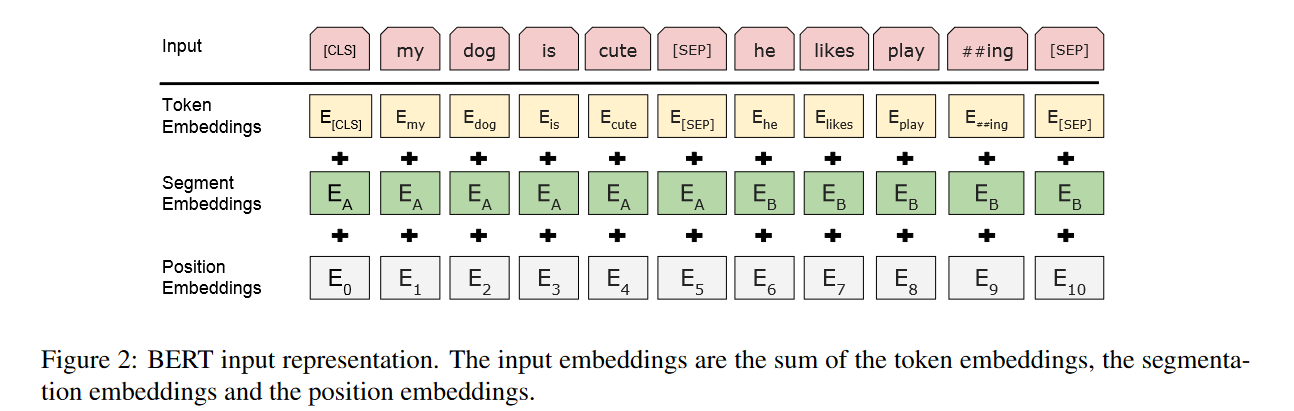

*Source: Devlin et al. (2019)*

In [ ]:
# 1. initial embeddings
# 1.1 word embeddings: fixed representation of words in the vocabulary that serve as the starting point of the model
# 1.2 position embeddings: fixed representation of each possible position within a sequence {0, 512}
# 1.3 token type embeddings: embeddings to distinguish real tokens from padding
print(model.embeddings)

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [ ]:
# 2. BERT's core: 12 layers of parameters
print(model.encoder)

BertEncoder(
  (layer): ModuleList(
    (0): BertLayer(
      (attention): BertAttention(
        (self): BertSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): BertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (intermediate): BertIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): BertOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       

In [ ]:
# 3. weigths to generate a final representation of the complete sequence for a classification task
print(model.pooler)

BertPooler(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
)


### Passing a sequence through the model

Generating a dense representation of a sequence with BERT entails a sequential process of passing the tokens of a sequence through the set of weigths that we inspected above.

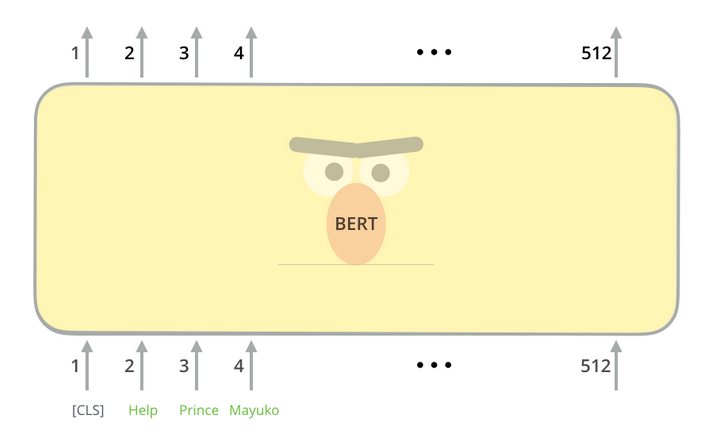

*Source: Jay Alammar (2018b)*

In [ ]:
# lets first get a single sentence as an example
sent_position = 92
sent = df.loc[sent_position, "sentences"]
print(sent + "\n")

# tokenize
sent_encoded = tokenizer(sent,  max_length=60, padding="max_length", truncation=True, return_tensors='pt')

We receive asset-based management fees based on the value of our clients' portfolios or investments in funds managed by us and, in some cases, we also receive performance fees based on increases in the value of such investments.



In [ ]:
# apply forward pass through the model (do not accumulate gradients; we are not training)
with torch.no_grad():
    result = model(**sent_encoded)

In [ ]:
# explore output from model
print(f"Number of hidden layers: {len(result.hidden_states)}")
print(f"Shape of output of each hidden layer: {result.hidden_states[5].shape}") # batch_size, number of tokens, embedding dimension
print(f"Shape of pooler output: {result.pooler_output.shape}") # batch_size, embedding dimension

Number of hidden layers: 13
Shape of output of each hidden layer: torch.Size([1, 60, 768])
Shape of pooler output: torch.Size([1, 768])


### Creating a sequence representation

There are several ways in which the output of BERT can be used to generate an embedded representation of a sequence of text. We will show some of them below. However, following the way in which BERT was pre-trained, we will focus on the embedded representation of the ```[CLS]``` token in the last hidden layer. This representation, is the one used to fullfil the next sentence prediction task on which BERT is trained.

In [ ]:
# use the embedding of the [CLS] token as the representation of the sequence
cls_emb = result.hidden_states[-1][0][0]
print(f"Shape of [CLS] embedding: {cls_emb.shape}")

Shape of [CLS] embedding: torch.Size([768])


In [ ]:
# we can also average the embeddings of all tokens in a given hidden state (e.g. layer 11)
avg_emb = torch.mean(result.hidden_states[-2][0], dim=0)
print(f"Shape of average embedding: {avg_emb.shape}")

Shape of average embedding: torch.Size([768])


# 3. Generating features for a regression model

We will use these sequence representations that we have constructed to estimate a regression where we want to predict the 2-digit NAICS sector of the firm that had any given sequence of text as part of their 10-K report. <br /> <br>

$$ \text{sector}_i = \beta_0  + ∑_{k=1}^{768} \beta_k \text{ embedded dim}_{k,i} $$

<br /> <br>

We could also just think about $\beta$ as a vector of parameters of dimension $(1, 768)$ and $\text{CLS}_i$ as the embedded representation of sequence $i$ with dimensions $(1, 768)$ as well. <br /> <br>

$$ \text{sector}_i = \beta_0  + \beta^{T} \text{  CLS}_{i} $$

### BERT features


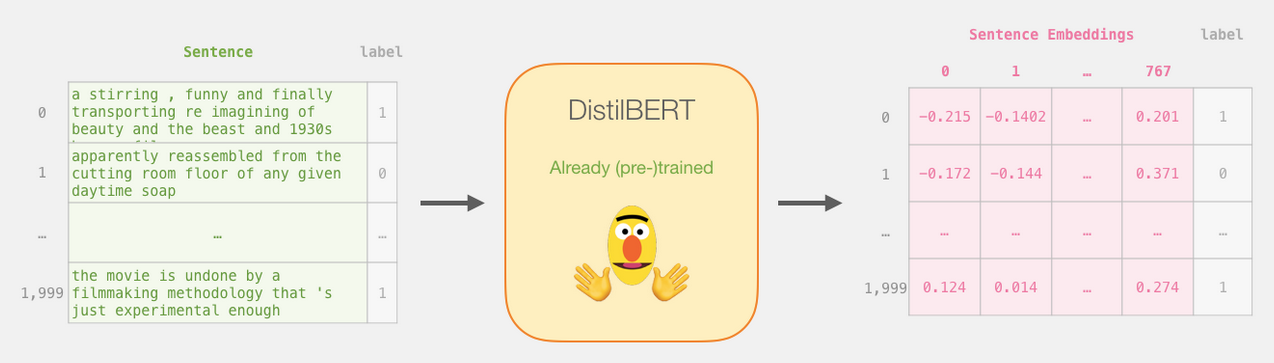

*Source: Jay Alammar (2018b)*

HuggingFace provides a very convenient interface for tokenizing and passing sequences through the model with few lines of code. To do this, we will use the ```pipeline()``` class. This class allows us to choose a particular task (e.g. features-extraction, text-classification) and, with the appropriate model and tokenizer, it will generate the correct output for the task (e.g. embedded features, classification probabilitites). All the available pipelines can be explored [here](https://huggingface.co/docs/transformers/main_classes/pipelines).

In [ ]:
# generate features from text using a pipeline object
feature_extraction = pipeline(task="feature-extraction",      # define the task
                              model=model,                    # model should be appropriate for the task
                              tokenizer=tokenizer,            # selected tokenizer
                              batch_size=16,                  # batching only supported for GPUs
                              device=0,                       # -1 for CPU and 0 for GPU
                              framework="pt"                  # data type 
                              )
# verify the task we selected
feature_extraction.task

'feature-extraction'

In [ ]:
# transform dataframe into Dataset class (easier to work with pipeline)
dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['sentences', 'cik', 'year', 'sent_no', 'sent_id', 'naics2', 'sentence_len', 'keep_sent'],
    num_rows: 6881
})

In [ ]:
# iterate through our sequences to extract the [CLS] embedding
all_cls = []
for out in tqdm(feature_extraction(KeyDataset(dataset, "sentences"),
                                   truncation=True, 
                                   max_length=60,
                                   padding=False)
                ):
    
    # extract the [CLS] embedding from all sentences
    all_cls.append(out[0][0])

  0%|          | 0/431 [00:00<?, ?it/s]

In [ ]:
# build a dataframe with the features obtained using BERT
df_features_bert = pd.DataFrame(all_cls)
df_features_bert

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.824839,-0.004663,-0.458257,-0.664349,-0.133645,-0.039018,-0.155485,0.280788,0.480075,-0.193740,...,-0.206574,-0.292948,-0.320678,-0.539839,-0.380370,0.073053,-0.489085,-0.318437,0.619741,0.440679
1,-0.369103,0.082162,-0.140538,-0.194881,-0.238333,-0.413052,0.269551,0.327644,0.107019,-0.212886,...,0.087334,-0.093014,0.079876,-0.250233,-0.068196,0.335318,-0.247243,-0.428237,0.268111,0.604181
2,-0.433662,0.031701,-0.500532,-0.002442,0.079371,-0.057810,-0.189215,0.499591,0.035364,0.071956,...,0.286745,-0.215691,0.007742,0.119517,-0.058923,0.277407,-0.012427,-0.266563,0.184173,0.475681
3,-0.371987,0.244763,-0.024678,-0.105449,0.145470,-0.010666,0.163713,0.164568,-0.260136,-0.265097,...,0.365448,-0.101897,0.159349,0.091368,0.162028,-0.466449,-0.007467,-0.059628,-0.006474,0.293165
4,-0.509347,0.245026,-0.325838,-0.351404,-0.158214,0.089533,-0.100730,0.706634,-0.016049,0.215428,...,0.005461,-0.109407,0.395645,0.076005,-0.056140,-0.225529,0.502456,-0.154571,0.237928,0.777848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6876,-0.227582,-0.172389,0.536662,-0.039504,0.132648,-0.312585,0.151738,-0.140320,0.089650,-0.462484,...,0.005394,0.064726,0.243955,-0.201387,-0.012337,-0.423015,-0.123359,0.155362,0.345266,0.481403
6877,-0.073973,0.056038,-0.006544,-0.051898,-0.151527,0.068489,0.358183,0.371048,0.424025,-0.356336,...,-0.266280,-0.085259,0.053851,-0.036734,-0.158663,-0.136171,0.038036,-0.386517,0.051225,0.345360
6878,-0.397435,0.080184,0.016017,0.373276,-0.316202,0.139613,-0.013124,0.159674,0.068774,-0.583276,...,0.072732,0.022394,0.071945,0.208614,0.027415,0.244744,-0.055598,-0.597297,0.303785,0.415648
6879,-0.641720,-0.102445,-0.131075,0.406779,-0.020079,-0.033183,-0.295510,0.254862,-0.240674,-0.299448,...,0.162494,-0.244313,0.099069,0.351340,0.286502,-0.213941,0.094505,-0.015592,0.047179,-0.113655


In [ ]:
# get only the NAICS2 code for each sentence to use as the labels for our regression
labels = df[["naics2"]]

In [ ]:
print(df_features_bert.shape, labels.shape)

(6881, 768) (6881, 1)


### Word2Vec features

We will also generate and embedded representation of sequences using word embeddings from a pre-trained word2vec model. This will enable us to compare the quality of the different features we generate. 

In [ ]:
# download the model and return as object ready for use
#w2v_model = api.load("word2vec-google-news-300") 
w2v_model = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
# explore some of the functionality of the model
w2v_model.most_similar("cat")

[('dog', 0.9218005537986755),
 ('rabbit', 0.8487821221351624),
 ('monkey', 0.804108202457428),
 ('rat', 0.7891963124275208),
 ('cats', 0.7865270376205444),
 ('snake', 0.7798910737037659),
 ('dogs', 0.7795814871788025),
 ('pet', 0.7792249917984009),
 ('mouse', 0.773166835308075),
 ('bite', 0.7728800177574158)]

In [ ]:
def w2v_embed(text, w2v_model):
    # lowercase all text
    lower_text = text.lower()
    # split sentence into words by spliting on white spaces
    words = lower_text.split(" ")

    # get the word2vec embedding of all words in the vocabulary
    word_embeddings = []
    for w in words:
        if w in w2v_model.index2word:
            word_emb = w2v_model[w]
            word_embeddings.append(word_emb)

    if word_embeddings:
        # generate a sequence embedding by averaging all embeddings
        word_embeddings = np.array(word_embeddings)
        seq_embedding = np.mean(word_embeddings, axis=0)
        return seq_embedding
    else:
        return np.nan

In [ ]:
# transform all sequences into their w2v embedded representation
all_w2v = []
valid_sents = []
for sent in tqdm(df["sentences"].values):
    seq_emb = w2v_embed(sent, w2v_model)
    if type(seq_emb) == np.ndarray:
        all_w2v.append(seq_emb)
        valid_sents.append(True)
    else:
        valid_sents.append(False)

print(len(all_w2v))

  0%|          | 0/6881 [00:00<?, ?it/s]

6867


In [ ]:
# build a dataframe with the features obtained using Word2Vec
df_features_w2v = pd.DataFrame(all_w2v)
df_features_w2v

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.540635,0.127384,-0.024680,0.080156,0.141954,0.337586,-0.076184,-0.027364,0.075695,-0.050544,...,-0.339042,-0.131969,0.165841,0.226975,0.119434,0.033201,0.048767,0.391214,0.036774,0.003522
1,0.572623,0.130122,0.008041,-0.045959,0.388011,0.355688,-0.111827,-0.097538,0.057579,0.074068,...,-0.262813,0.000722,0.185466,0.440187,-0.022984,0.044124,-0.080158,0.404378,0.017113,-0.034463
2,0.391365,0.005382,0.083895,0.025353,0.147719,0.416932,0.002857,-0.167977,0.016022,0.051839,...,-0.361934,-0.047508,0.274480,0.191729,-0.079441,-0.122974,-0.136502,0.247771,0.174222,-0.036685
3,0.369290,-0.840340,-0.302120,1.091700,-0.671490,0.152260,1.012300,-0.403270,1.085500,-0.189210,...,-0.774240,-0.329790,0.499250,1.268900,-0.725240,0.277680,0.112760,1.133500,0.149850,0.293500
4,0.395089,-0.086363,-0.022445,0.090727,0.067340,0.267860,-0.454639,-0.320522,0.014408,-0.061528,...,-0.361047,-0.086976,0.350621,0.265505,0.041290,-0.054652,-0.263355,0.204740,0.025171,0.026613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6862,0.271729,0.266269,-0.080200,-0.106493,0.208868,0.155222,-0.293767,-0.187858,0.076642,-0.310106,...,-0.372105,-0.354283,-0.010724,-0.090252,-0.602180,-0.012525,-0.107165,-0.056447,-0.101903,-0.260219
6863,0.343492,0.074846,0.082800,-0.235107,0.171213,0.176282,-0.123969,-0.229041,0.025236,0.024813,...,-0.479751,-0.043635,0.244478,0.132521,-0.009665,-0.002167,-0.147342,0.330674,-0.059967,0.012858
6864,0.392047,0.225411,0.281975,-0.212545,0.164222,0.137184,-0.027680,-0.348824,0.269498,0.143668,...,-0.304939,0.005752,0.311117,0.067613,-0.256938,-0.172026,-0.202377,0.332080,0.122707,-0.104356
6865,0.401437,0.094827,0.065122,0.025335,0.104752,0.321912,-0.184658,-0.312649,-0.096009,0.113288,...,-0.302504,-0.013798,0.403039,0.273546,-0.000281,-0.066570,-0.180412,0.169319,-0.074610,-0.030664


In [ ]:
# get only the labels for those sentences with w2v embeddings
labels_w2v = labels[valid_sents]
labels_w2v.reset_index(drop=True, inplace=True)
len(labels_w2v), len(df_features_w2v)

(6867, 6867)

In [ ]:
# # train Gensim's Word2Vec model
# gensim_model = Word2Vec(sentences=prep.tokens,      # corpus
#                         vector_size=100,            # embedding dimension
#                         window=4,                   # words before and after to take into consideration
#                         sg=1,                       # use skip-gram
#                         negative=5,                 # number of negative examples for each positive one
#                         alpha=0.025,                # initial learning rate
#                         min_alpha=0.0001,           # minimum learning rate
#                         epochs=5,                   # number of passes through the data
#                         min_count=1,                # words that appear less than this are removed
#                         workers=1,                  # we use 1 to ensure replicability
#                         seed=92                     # for replicability
#                        )

In [ ]:
# restrict BERT features to those sentences for which we have a w2v embedding
df_features_bert = df_features_bert[valid_sents]
df_features_bert.reset_index(drop=True, inplace=True)
len(df_features_bert), len(df_features_bert)

(6867, 6867)

### Estimate regressions

In [ ]:
# create list with all the indexes of available sentences
sent_idxs = list(range(0, len(labels_w2v)))
len(sent_idxs)

6867

In [ ]:
# perform a train/test split
train_idxs, test_idxs = train_test_split(sent_idxs, test_size=0.2, random_state=92)
print(f"Train sentences: {len(train_idxs)}\n", f"Test sentences: {len(test_idxs)}")

Train sentences: 5493
 Test sentences: 1374


In [ ]:
# select idxs for training and testing

# BERT
train_bert_features = df_features_bert.loc[train_idxs]
test_bert_features = df_features_bert.loc[test_idxs]

# Word2Vec
train_w2v_features = df_features_w2v.loc[train_idxs]
test_w2v_features = df_features_w2v.loc[test_idxs]

# Labels
train_labels = labels_w2v.loc[train_idxs]
test_labels = labels_w2v.loc[test_idxs]

In [ ]:
# BERT: fit a multinomial logistic regression to predict the sector of each sentence
lr_bert = LogisticRegression(penalty="l2",
                             multi_class = "multinomial",
                             solver="lbfgs",
                             max_iter=100000)

lr_bert.fit(train_bert_features, train_labels.values.ravel())

# Word2Vec: fit a multinomial logistic regression to predict the sector of each sentence
lr_w2v = LogisticRegression(penalty="l2",
                            multi_class = "multinomial",
                            solver="lbfgs",
                            max_iter=100000)

lr_w2v.fit(train_w2v_features, train_labels.values.ravel())

LogisticRegression(max_iter=100000, multi_class='multinomial')

In [ ]:
# get in sample predictions for both models
pred_train_bert = lr_bert.predict(train_bert_features)
pred_train_w2v = lr_w2v.predict(train_w2v_features)

print(f"Random guess accuracy: {1/len(df.groupby('naics2').size())}\n")

print("===========================\nBERT results:")
train_acc_bert = accuracy_score(train_labels, pred_train_bert)
print(f"In sample accuracy: {train_acc_bert}")
train_f1_bert = f1_score(train_labels, pred_train_bert, average="micro")
print(f"In sample F1 score: {train_f1_bert}")
train_precision_bert = precision_score(train_labels, pred_train_bert, average="micro")
print(f"In sample precision score: {train_precision_bert}")
train_recall_bert = recall_score(train_labels, pred_train_bert, average="micro")
print(f"In sample recall score: {train_recall_bert}")

print("\n===========================\nWord2Vec results:")
train_acc_w2v = accuracy_score(train_labels, pred_train_w2v)
print(f"In sample accuracy: {train_acc_w2v}")
train_f1_w2v = f1_score(train_labels, pred_train_w2v, average="micro")
print(f"In sample F1 score: {train_f1_w2v}")
train_precision_w2v = precision_score(train_labels, pred_train_w2v, average="micro")
print(f"In sample precision score: {train_precision_w2v}")
train_recall_w2v = recall_score(train_labels, pred_train_w2v, average="micro")
print(f"In sample recall score: {train_recall_w2v}")

Random guess accuracy: 0.25

BERT results:
In sample accuracy: 0.7806298925905698
In sample F1 score: 0.7806298925905698
In sample precision score: 0.7806298925905698
In sample recall score: 0.7806298925905698

Word2Vec results:
In sample accuracy: 0.530129255415984
In sample F1 score: 0.530129255415984
In sample precision score: 0.530129255415984
In sample recall score: 0.530129255415984


In [ ]:
# get out-of-sample predictions for both models
pred_test_bert = lr_bert.predict(test_bert_features)
pred_test_w2v = lr_w2v.predict(test_w2v_features)


print(f"Random guess accuracy: {1/len(df.groupby('naics2').size())}\n")

print("===========================\nBERT results:")
test_acc_bert = accuracy_score(test_labels, pred_test_bert)
print(f"Test accuracy: {test_acc_bert}")
test_f1_bert = f1_score(test_labels, pred_test_bert, average="micro")
print(f"Test F1 score: {test_f1_bert}")
test_precision_bert = precision_score(test_labels, pred_test_bert, average="micro")
print(f"Test precision score: {test_precision_bert}")
test_recall_bert = recall_score(test_labels, pred_test_bert, average="micro")
print(f"Test recall score: {test_recall_bert}")

print("\n===========================\nWord2Vec results:")
test_acc_w2v = accuracy_score(test_labels, pred_test_w2v)
print(f"Test accuracy: {test_acc_w2v}")
test_f1_w2v = f1_score(test_labels, pred_test_w2v, average="micro")
print(f"Test F1 score: {test_f1_w2v}")
test_precision_w2v = precision_score(test_labels, pred_test_w2v, average="micro")
print(f"Test precision score: {test_precision_w2v}")
test_recall_w2v = recall_score(test_labels, pred_test_w2v, average="micro")
print(f"Test recall score: {test_recall_w2v}")

Random guess accuracy: 0.25

BERT results:
Test accuracy: 0.6200873362445415
Test F1 score: 0.6200873362445415
Test precision score: 0.6200873362445415
Test recall score: 0.6200873362445415

Word2Vec results:
Test accuracy: 0.5429403202328966
Test F1 score: 0.5429403202328966
Test precision score: 0.5429403202328966
Test recall score: 0.5429403202328966


In [ ]:
# compare the 2 methods
df_compare = pd.DataFrame({"accuracy": [test_acc_w2v, test_acc_bert],
                           "model": ["word2vec", "BERT"]})
df_compare

,accuracy,model
0,0.542940,word2vec
1,0.620087,BERT


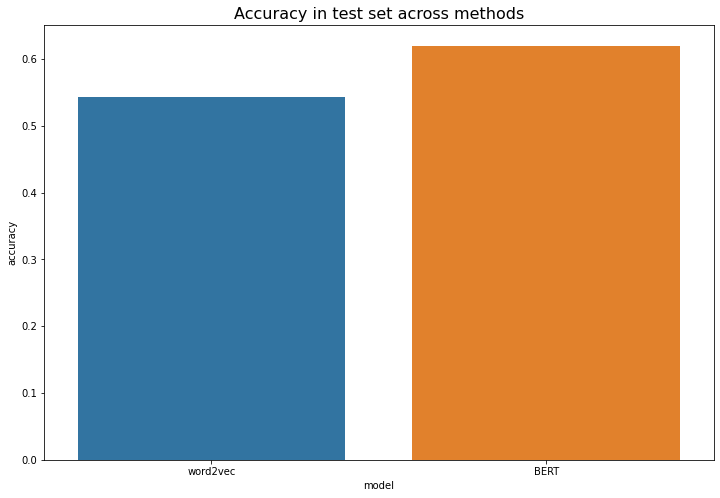

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=df_compare, x="model", y="accuracy")
plt.title("Accuracy in test set across methods", fontsize=16)
plt.show()

### Out-of-corpus sentence

We can now use out estimated regression to predict the sector of any given sequence of text we migth imagine. We will demonstrate this by using BERT.

In [ ]:
# define a target sentence
outside_target = "We are worried about misinformation and fake news."

# tokenize sentence
outside_tokens = tokenizer(outside_target, return_tensors='pt')
outside_tokens = outside_tokens.to("cuda")  # required when using GPU

# apply forward pass through the model (do not accumulate gradients; we are not training)
with torch.no_grad():
    result = model(**outside_tokens, output_attentions=True)

# extract [CLS] token embedding from last layer
outside_cls_emb = result.hidden_states[-1][0][0]
outside_cls_emb = outside_cls_emb.cpu() # required when using GPU
print(f"Shape of [CLS] embedding: {outside_cls_emb.shape}")

Shape of [CLS] embedding: torch.Size([768])


In [ ]:
# generate class prediction for out-of-corpus sentence
outside_prediction = lr_bert.predict(outside_cls_emb.numpy().reshape(1, -1))
print(f"Predicted NAICS2 code: {outside_prediction[0]}")

# transform sector code into name
prediction_name = df_naics.loc[df_naics["Sector"] == outside_prediction[0]]["Description"].values[0]
print(f"Predicted NAICS2 sector: {prediction_name}\n--------\n")

# generate probability predictions for out-of-corpus sentence
outside_probs = lr_bert.predict_proba(outside_cls_emb.numpy().reshape(1, -1))
outside_probs

for prob, code in zip(outside_probs[0], lr_bert.classes_):
    code_name = df_naics.loc[df_naics["Sector"] == code]["Description"].values[0]
    print(f"Predicted probability for {code_name}: {np.round(prob,3)}")

Predicted NAICS2 code: 51
Predicted NAICS2 sector: Information
--------

Predicted probability for Manufacturing: 0.003
Predicted probability for Retail Trade: 0.117
Predicted probability for Information: 0.873
Predicted probability for Finance and Insurance: 0.007


In [ ]:
# define a target sentence
outside_target = "Our production of cars is affected by the price of steel."

# tokenize sentence
outside_tokens = tokenizer(outside_target, return_tensors='pt')
outside_tokens = outside_tokens.to("cuda")  # required when using GPU

# apply forward pass through the model (do not accumulate gradients; we are not training)
with torch.no_grad():
    result = model(**outside_tokens, output_attentions=True)

# extract [CLS] token embedding from last layer
outside_cls_emb = result.hidden_states[-1][0][0]
outside_cls_emb = outside_cls_emb.cpu() # required when using GPU
print(f"Shape of [CLS] embedding: {outside_cls_emb.shape}")

# generate class prediction for out-of-corpus sentence
outside_prediction = lr_bert.predict(outside_cls_emb.numpy().reshape(1, -1))
print(f"Predicted NAICS2 code: {outside_prediction[0]}")

# transform sector code into name
prediction_name = df_naics.loc[df_naics["Sector"] == outside_prediction[0]]["Description"].values[0]
print(f"Predicted NAICS2 sector: {prediction_name}\n--------\n")

# generate probability predictions for out-of-corpus sentence
outside_probs = lr_bert.predict_proba(outside_cls_emb.numpy().reshape(1, -1))
outside_probs

for prob, code in zip(outside_probs[0], lr_bert.classes_):
    code_name = df_naics.loc[df_naics["Sector"] == code]["Description"].values[0]
    print(f"Predicted probability for {code_name}: {np.round(prob,3)}")

Shape of [CLS] embedding: torch.Size([768])
Predicted NAICS2 code: 33
Predicted NAICS2 sector: Manufacturing
--------

Predicted probability for Manufacturing: 0.982
Predicted probability for Retail Trade: 0.011
Predicted probability for Information: 0.005
Predicted probability for Finance and Insurance: 0.002


In [ ]:
# define a target sentence
outside_target = "The decisions from the federal reserve board can affect us greatly."

# tokenize sentence
outside_tokens = tokenizer(outside_target, return_tensors='pt')
outside_tokens = outside_tokens.to("cuda")  # required when using GPU

# apply forward pass through the model (do not accumulate gradients; we are not training)
with torch.no_grad():
    result = model(**outside_tokens, output_attentions=True)

# extract [CLS] token embedding from last layer
outside_cls_emb = result.hidden_states[-1][0][0]
outside_cls_emb = outside_cls_emb.cpu() # required when using GPU
print(f"Shape of [CLS] embedding: {outside_cls_emb.shape}")

# generate class prediction for out-of-corpus sentence
outside_prediction = lr_bert.predict(outside_cls_emb.numpy().reshape(1, -1))
print(f"Predicted NAICS2 code: {outside_prediction[0]}")

# transform sector code into name
prediction_name = df_naics.loc[df_naics["Sector"] == outside_prediction[0]]["Description"].values[0]
print(f"Predicted NAICS2 sector: {prediction_name}\n--------\n")

# generate probability predictions for out-of-corpus sentence
outside_probs = lr_bert.predict_proba(outside_cls_emb.numpy().reshape(1, -1))
outside_probs

for prob, code in zip(outside_probs[0], lr_bert.classes_):
    code_name = df_naics.loc[df_naics["Sector"] == code]["Description"].values[0]
    print(f"Predicted probability for {code_name}: {np.round(prob,3)}")

Shape of [CLS] embedding: torch.Size([768])
Predicted NAICS2 code: 52
Predicted NAICS2 sector: Finance and Insurance
--------

Predicted probability for Manufacturing: 0.003
Predicted probability for Retail Trade: 0.001
Predicted probability for Information: 0.001
Predicted probability for Finance and Insurance: 0.995


# 4. Domain-specific models

So far, we have used the base version of BERT to generate features. However, one concern with this approach is that the language in the training data used for base BERT (i.e. Wikipedia and Books) migth be very different from the language in 10-K reports. In order to alleviate this concern, we will use a different version of the model trained on 260,773 10-K filings from 1993-2019,
publicly available at U.S. Securities and Exchange Commission (SEC).

These family of models are called [```SEC-BERT```](https://huggingface.co/nlpaueb/sec-bert-shape) and were developed by the Natural Language Processing Group at the Athens University of Economics and Business. ```SEC-BERT``` consists of the following models:

- ```SEC-BERT-BASE```: Same architecture as BERT-BASE trained on financial documents.
- ```SEC-BERT-NUM```: Same as SEC-BERT-BASE but we replace every number token with a [NUM] pseudo-token handling all numeric expressions in a uniform manner, disallowing their fragmentation)
- ```SEC-BERT-SHAPE```: Same as SEC-BERT-BASE but we replace numbers with pseudo-tokens that represent the number’s shape, so numeric expressions (of known shapes) are no longer fragmented, e.g., '53.2' becomes '[XX.X]' and '40,200.5' becomes '[XX,XXX.X]'.

> You can use [HuggingFace's interface](https://huggingface.co/models) to explore more models trained on different corpora.

In [ ]:
# load a tokenizer using the name of the model we want to use
sec_tokenizer = AutoTokenizer.from_pretrained("nlpaueb/sec-bert-base")
# inspect the configuration of the tokenizer
sec_tokenizer

Downloading:   0%|          | 0.00/263 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/216k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='nlpaueb/sec-bert-base', vocab_size=30000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
# load the model trained on 10-K report using its name
sec_model = BertModel.from_pretrained("nlpaueb/sec-bert-base")

# put model in evaluation model (we will not do any training)
sec_model = sec_model.eval()

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at nlpaueb/sec-bert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# we will use the pipeline object again (but with the new model and tokenizer)
sec_feature_extraction = pipeline(task="feature-extraction",          # define the task
                                  model=sec_model,                    # model should be appropriate for the task
                                  tokenizer=sec_tokenizer,            # selected tokenizer
                                  batch_size=16,                      # batching only supported for GPUs
                                  device=0,                           # -1 for CPU and 0 for GPU
                                  framework="pt"                      # data type 
                                 )
sec_feature_extraction.task

'feature-extraction'

In [ ]:
# iterate through our sequences to extract the [CLS] embedding
all_cls_sec = []
for out in tqdm(sec_feature_extraction(KeyDataset(dataset, "sentences"),
                                       truncation=True, 
                                       max_length=60,
                                       padding=False)):
    
    # extract the [CLS] embedding from all sentences
    all_cls_sec.append(out[0][0])

  0%|          | 0/431 [00:00<?, ?it/s]

In [ ]:
# build a dataframe with the features obtained using SEC BERT
df_features_sec = pd.DataFrame(all_cls_sec)
df_features_sec = df_features_sec[valid_sents]
df_features_sec.reset_index(drop=True, inplace=True)
df_features_sec

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.376939,-0.140579,-0.428750,0.295815,0.271135,-0.164485,0.030321,-0.265742,0.385735,0.260340,...,0.003370,0.311562,0.087359,-0.083941,0.553148,-0.227894,0.388406,-0.601551,-0.316129,-0.123313
1,0.533621,0.050102,-0.311264,0.495807,-0.068415,-0.264094,-0.088142,-0.010287,0.499246,0.296850,...,-0.532170,0.676393,0.216192,-0.342862,0.676646,-0.031884,0.256060,-0.351445,-0.312331,0.000427
2,0.408385,0.025169,-0.312309,0.154126,0.127272,-0.208127,-0.052731,-0.392785,0.280328,0.131218,...,-0.449753,0.467373,0.133385,0.088486,0.388907,0.141991,0.312776,-0.499311,-0.306896,0.205140
3,0.207332,-0.033315,0.065421,0.077736,-0.124575,0.017116,-0.296445,0.308948,0.387347,-0.151151,...,-0.472491,0.252697,0.066477,-0.421531,0.070957,0.135588,0.084833,0.093277,-0.221431,-0.300587
4,0.254688,0.179559,-0.061918,-0.161153,0.315859,0.179094,0.210361,-0.021678,-0.120718,0.121269,...,-0.608426,-0.188357,0.292631,-0.129270,0.717630,-0.479501,0.290856,-0.702829,-0.505195,0.168606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6862,0.112713,0.065506,0.354329,0.322967,0.433435,0.116433,-0.329728,-0.267637,-0.343811,0.358039,...,-0.284816,0.245086,-0.071225,0.264397,0.200994,-0.549518,-0.370566,0.173479,-0.359638,-0.223028
6863,0.084064,-0.047359,-0.087702,-0.107320,-0.081662,-0.226985,-0.772778,-0.170689,-0.044984,-0.238042,...,-0.243460,0.212811,0.003241,-0.217476,0.059930,-0.089975,-0.724974,-0.332189,-0.361057,0.164427
6864,0.460133,0.103868,-0.123414,-0.395757,-0.081955,-0.298238,-0.544906,-0.214941,-0.178918,0.107353,...,0.033614,0.328426,0.006384,-0.299188,-0.009477,-0.327203,-0.566448,-0.401379,-0.308110,0.142149
6865,0.635484,-0.012616,-0.035677,-0.500130,0.373538,-0.077321,-0.458545,-0.192690,-0.322041,-0.010694,...,-0.186516,-0.092872,0.085294,-0.118705,-0.031655,-0.133606,-0.254461,-0.224571,-0.427602,0.190125


In [ ]:
# split features using the previous train/test split
train_sec_features = df_features_sec.loc[train_idxs]
test_sec_features = df_features_sec.loc[test_idxs]

In [ ]:
# fit a logistic regression to predict the sector of each sentence
lr_sec = LogisticRegression(penalty="l2",
                            multi_class = "multinomial",
                            solver="lbfgs",
                            max_iter=100000)

lr_sec.fit(train_sec_features, train_labels.values.ravel())

LogisticRegression(max_iter=100000, multi_class='multinomial')

In [ ]:
# get in sample predictions
pred_train_sec = lr_sec.predict(train_sec_features)

print(f"Random guess accuracy: {1/len(df.groupby('naics2').size())}\n")

print("===========================\nIn sample SEC BERT results:")
train_acc_sec = accuracy_score(train_labels, pred_train_sec)
print(f"In sample accuracy: {train_acc_sec}")
train_f1_sec = f1_score(train_labels, pred_train_sec, average="micro")
print(f"In sample F1 score: {train_f1_sec}")
train_precision_sec = precision_score(train_labels, pred_train_sec, average="micro")
print(f"In sample precision score: {train_precision_sec}")
train_recall_sec = recall_score(train_labels, pred_train_sec, average="micro")
print(f"In sample recall score: {train_recall_sec}")

# get out-of-sample predictions
pred_test_sec = lr_sec.predict(test_sec_features)

print("===========================\nOut of sample SEC BERT results:")
test_acc_sec = accuracy_score(test_labels, pred_test_sec)
print(f"Test accuracy: {test_acc_sec}")
test_f1_sec = f1_score(test_labels, pred_test_sec, average="micro")
print(f"Test F1 score: {test_f1_sec}")
test_precision_sec = precision_score(test_labels, pred_test_sec, average="micro")
print(f"Test precision score: {test_precision_sec}")
test_recall_sec = recall_score(test_labels, pred_test_sec, average="micro")
print(f"Test recall score: {test_recall_sec}")

Random guess accuracy: 0.25

In sample SEC BERT results:
In sample accuracy: 0.8405243036592026
In sample F1 score: 0.8405243036592026
In sample precision score: 0.8405243036592026
In sample recall score: 0.8405243036592026
Out of sample SEC BERT results:
Test accuracy: 0.6957787481804949
Test F1 score: 0.6957787481804949
Test precision score: 0.6957787481804949
Test recall score: 0.6957787481804949


In [ ]:
# compare all 3 methods
df_compare = pd.DataFrame({"accuracy": [test_acc_w2v, test_acc_bert, test_acc_sec],
                           "model": ["word2vec", "BERT", "SEC BERT"]})
df_compare

,accuracy,model
0,0.542940,word2vec
1,0.620087,BERT
2,0.695779,SEC BERT


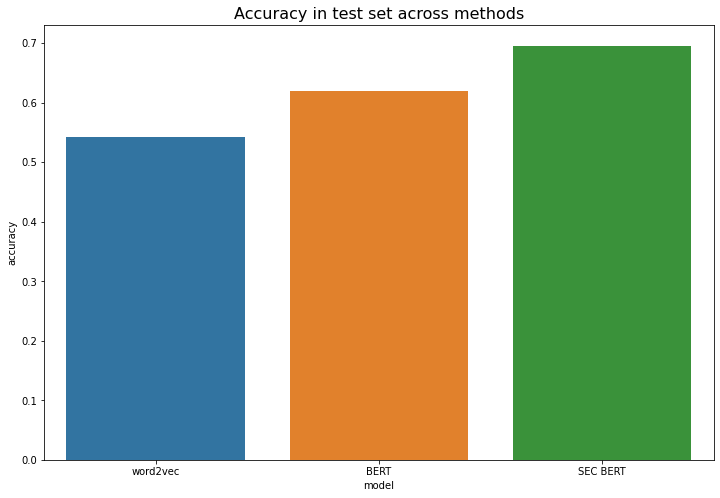

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=df_compare, x="model", y="accuracy")
plt.title("Accuracy in test set across methods", fontsize=16)
plt.show()

# 5. Finetuning a model

Lastly, we will show how we can finetune a BERT model for any classification task we want.

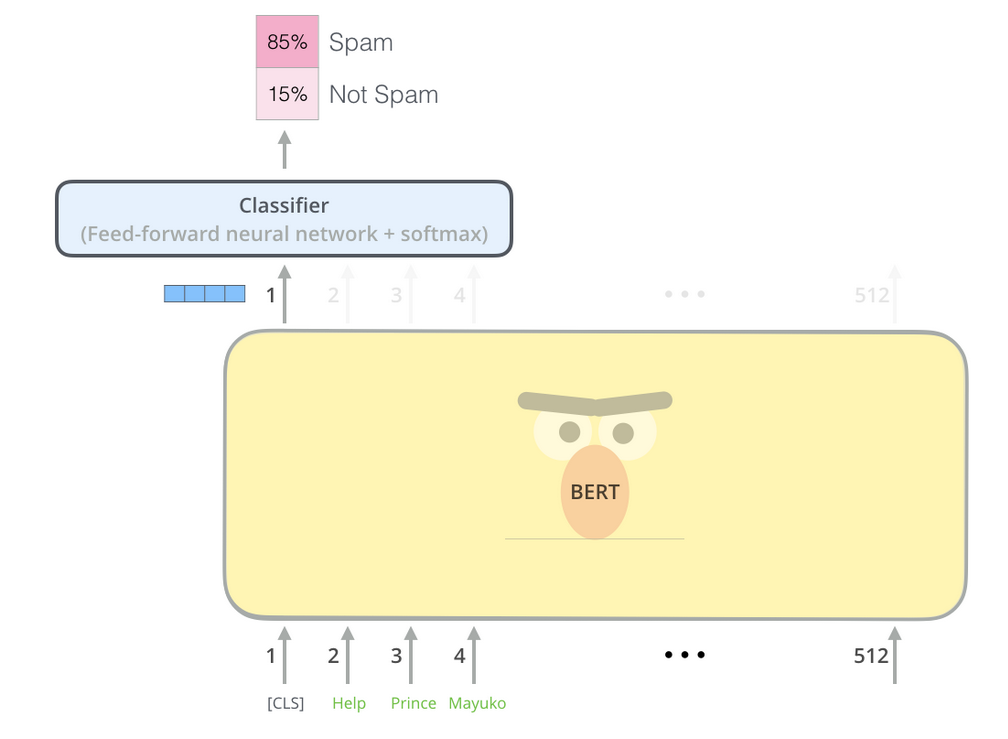

In [ ]:
# format the data adequately
df_finetune = df.loc[train_idxs].copy()

df_finetune = df_finetune[["sentences", "naics2"]]
df_finetune.columns = ["sentences", "label"]

# transform labels into integers
df_finetune["label"] = df_finetune["label"].astype(int)
df_finetune

# map labels from original sector code to ints from 0 to num_sectors
num_sectors = len(df_finetune.groupby('label').size())
label2id_label = {k:v for k,v in zip(df_finetune.groupby('label').size().index.values, range(0, num_sectors))}
df_finetune["label"] = df_finetune["label"].apply(lambda x: label2id_label[x])
df_finetune

,sentences,label
4668,"Because of these and other factors, competitiv...",2
6547,"Targeting the wrong opportunities, failing to ...",1
1974,Third parties may use us as a conduit for ille...,3
1016,Our actions to combat spam and fake accounts r...,2
649,It is unknown whether any banks will continue ...,0
...,...,...
5007,Our ability to meet our changing labor needs w...,1
710,Our success depends on our ability to provide ...,2
6162,A common stock and 38.9% of FOX class B common...,2
4138,• Cultural challenges associated with integrat...,2


In [ ]:
# format the data adequately
df_test = df.loc[test_idxs].copy()

df_test = df_test[["sentences", "naics2"]]
df_test.columns = ["sentences", "label"]

# transform labels into integers
df_test["label"] = df_test["label"].astype(int)
df_test

# map labels from original sector code to ints from 0 to num_sectors
df_test["label"] = df_test["label"].apply(lambda x: label2id_label[x])
df_test

,sentences,label
3061,"Furthermore, embargoes and sanctions imposed b...",0
1603,"Our risk reporting and management, including b...",3
6537,A failure to adequately update our existing sy...,1
6294,If the Company's supply of components for a ne...,0
912,"Errors, vulnerabilities, or other design defec...",2
...,...,...
3059,Due to the international scope of our operatio...,0
5451,If we are unable to offer a wide variety of co...,1
2839,You can identify forward-looking statements by...,0
756,• the impact of new technologies that could b...,2


In [ ]:
# transform into Dataset class
finetune_dataset = Dataset.from_pandas(df_finetune)
test_dataset = Dataset.from_pandas(df_test)

In [ ]:
# tokenize the dataset
def tokenize_function(examples):
    return sec_tokenizer(examples["sentences"], max_length=60, padding="max_length", truncation=True)

tokenized_ft = finetune_dataset.map(tokenize_function, batched=True)    # batched=True is key for training
tokenized_test = test_dataset.map(tokenize_function, batched=True)

tokenized_ft

Parameter 'function'=<function tokenize_function at 0x7f0be07913b0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Dataset({
    features: ['sentences', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5493
})

In [ ]:
# load the model for finetunning. Note that we use a different class from the transformers library:
# BertModel vs. BertForSequenceClassification

num_labels = len(df_finetune.groupby('label').size())
model_ft = BertForSequenceClassification.from_pretrained("nlpaueb/sec-bert-base", num_labels=num_labels)

Some weights of the model checkpoint at nlpaueb/sec-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

In [ ]:
# define the main arguments for training
training_args = TrainingArguments("./",                             # path to save model
                                  learning_rate=3e-5,               # very small learning rate
                                  num_train_epochs=3,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  evaluation_strategy="epoch",
                                  save_strategy="no")

In [ ]:
# define the set of metrics to be computed through the training process
def compute_metrics(eval_pred):
    metric1 = load_metric("precision")
    metric2 = load_metric("recall")
    metric3 = load_metric("f1")
    metric4 = load_metric("accuracy")
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    precision = metric1.compute(predictions=predictions, references=labels, average="micro")["precision"]
    recall = metric2.compute(predictions=predictions, references=labels, average="micro")["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels, average="micro")["f1"]
    accuracy = metric4.compute(predictions=predictions, references=labels)["accuracy"]
    
    return {"precision": precision, "recall": recall, 
            "f1": f1, "accuracy": accuracy}

# by default the Trainer will use MSEloss from (torch.nn) for regression and
# CrossEntropy loss for classification
trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=tokenized_ft,
    eval_dataset=tokenized_ft,  # in-sample evaluation
    compute_metrics=compute_metrics
)

In [ ]:
# train model (should take around 5 minutes with GPU)
trainer.train()

# save final version of the model
#trainer.save_model("./models/")

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentences. If __index_level_0__, sentences are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5493
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2061


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.794900,0.420307,0.837612,0.837612,0.837612,0.837612
2,0.533800,0.202709,0.930093,0.930093,0.930093,0.930093
3,0.228100,0.108711,0.964318,0.964318,0.964318,0.964318


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentences. If __index_level_0__, sentences are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5493
  Batch size = 8


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentences. If __index_level_0__, sentences are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5493
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentences. If __index_level_0__, sentences are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5493
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2061, training_loss=0.47306814938711345, metrics={'train_runtime': 330.4486, 'train_samples_per_second': 49.869, 'train_steps_per_second': 6.237, 'total_flos': 508111516429920.0, 'train_loss': 0.47306814938711345, 'epoch': 3.0})

In [ ]:
# evaluate final model on full test dataset
results = trainer.predict(tokenized_test)
final_metrics = results[2]
print(final_metrics)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentences. If __index_level_0__, sentences are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1374
  Batch size = 8


{'test_loss': 0.8056644201278687, 'test_precision': 0.7933042212518195, 'test_recall': 0.7933042212518195, 'test_f1': 0.7933042212518195, 'test_accuracy': 0.7933042212518195, 'test_runtime': 6.4397, 'test_samples_per_second': 213.362, 'test_steps_per_second': 26.709}


In [ ]:
# compare all 4 methods
df_compare = pd.DataFrame({"accuracy": [test_acc_w2v, test_acc_bert, test_acc_sec, final_metrics["test_accuracy"]],
                           "model": ["word2vec", "BERT", "SEC BERT", "Finetuned BERT"]})
df_compare

,accuracy,model
0,0.542940,word2vec
1,0.620087,BERT
2,0.695779,SEC BERT
3,0.793304,Finetuned BERT


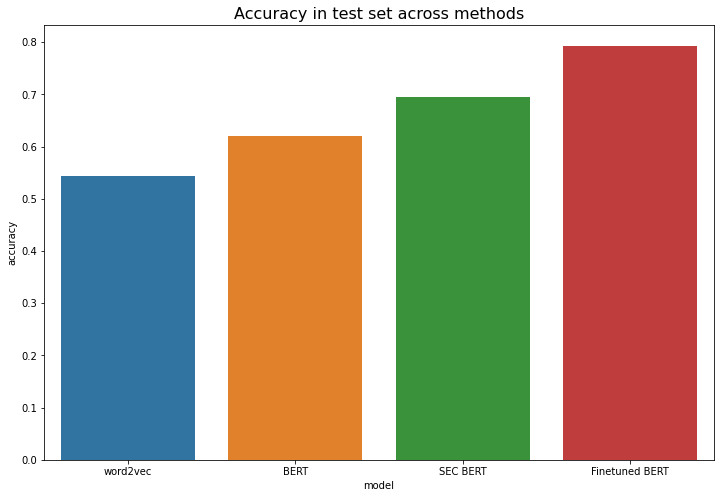

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=df_compare, x="model", y="accuracy")
plt.title("Accuracy in test set across methods", fontsize=16)
plt.show()

In [ ]:
# TODO: the cleanest way to compare finetuned BERT with the rest of the models would be to apply exactly the same procedure. 
# Thus, I need to save the model after finetuning and create a pipeline. Then train the logistic regresion.